In [90]:
import pandas as pd
import string
import os
import itertools
import numpy as np
from sqlalchemy import create_engine, text

from utils import DbEngine, Queries
from etl import ETL
from encoder import Encoding

In [74]:
import numpy as np
import sys

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import calinski_harabasz_score, fowlkes_mallows_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import accuracy_score, average_precision_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

from scipy.spatial import distance

import matplotlib.pyplot as plt
import seaborn as sns 
plt.style.use('seaborn')

### Connect to DB

In [3]:
db_engine = DbEngine(user = 'team77', 
                     password = 'mintic2020.',
                     ip = '172.17.0.3', 
                     port = '5432', 
                     db = 'minjusticia')
engine = db_engine.connect()
queries = Queries(engine)

### Loading original data

In [3]:
data = pd.read_excel('../data/ReincidenciaPospenadosNal201011Junio2020Rev.xlsx', skiprows = 6)

### Execute ETL

In [6]:
etl = ETL(queries)
etl.inmate_static_info(data)
etl.inmate_variable_info(data)

/home/jovyan/work/MinJusticia_team77_DS4A_Project/app/etl.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reg['CONDIC_EXPECIONAL'] = data_reg['CONDIC_EXPECIONAL'].fillna('NINGUNO')
/home/jovyan/work/MinJusticia_team77_DS4A_Project/app/etl.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reg['madre_gestante'] = 'NA'
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

### Encode

In [4]:
encoding = Encoding(queries)
data_2_encode = encoding.get_data()
data_encoded = encoding.one_hot(data_2_encode)
data_encoded

,internoen,genero,nacionalidad,reincidente,anio_nacimiento,estado_civil,nivel_educativo,reconocimiento_etnico,diversidad_sexual,extranjero,...,delito_id_delito_172,delito_id_delito_232,delito_id_delito_262,delito_id_delito_other,tentativa_1,tentativa_2,agravado_1,agravado_2,calificado_1,calificado_2
0,FD8EB8482F09C3F5FD085E4CAD29122368A5937B,2,22,2,1985,3,2,5,1,1,...,0,0,0,0,1,0,0,1,0,1
1,7624E0648E28D778D1EE4581998B00C3ABC061DA,2,22,2,1987,3,4,1,1,1,...,0,0,0,1,1,0,1,0,1,0
2,2660D0E0F43523200EF105604266F18D6CA396E5,2,22,2,1973,3,3,5,1,1,...,0,1,0,0,1,0,1,0,1,0
3,00CD632E133B134F4CD3659080F8E5E7C1C7330A,2,22,2,1970,3,3,5,1,1,...,0,0,1,0,1,0,1,0,1,0
4,7790E7531D616FDA7825C9CBB5502DD82DF35EB5,2,22,2,1988,1,5,5,1,1,...,0,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103285,C476DC9C78CBC61BC5A3D27699595E916D90E3E2,2,22,2,1985,6,2,5,1,1,...,0,1,0,0,1,0,1,0,1,0
103286,AEB9E4C6773CBBE7C8424A52AB686E9F14101E73,2,22,2,1985,7,10,5,1,1,...,0,0,0,1,1,0,1,0,1,0
103287,92FBC965E9DE8CE7CD6AF95F4C460AF9A788CF59,2,22,2,1999,6,4,5,1,1,...,0,0,0,0,1,0,0,1,0,1
103288,BE6DD3C2939188AAFE3CD16E971D7F6C2BCEBC73,2,22,2,1978,7,2,5,1,1,...,0,0,0,0,2,0,1,1,1,1


### Unsupervised Learning with Kmeans

#### Fixing dataset lasts issues

Evaluando cantidad de columnas vacias aún

In [5]:
data_encoded.isnull().sum().to_frame().rename(columns={0:'counts'}).sort_values(by='counts', ascending = False)

,counts
fecha_salida,30304
internoen,0
madre_gestante,0
discapacidad,0
adulto_mayor,0
delito_id_delito_42,0
delito_id_delito_102,0
delito_id_delito_103,0
delito_id_delito_105,0
delito_id_delito_109,0


Evaluando qué columnas colo tienen un valor, pues de deben eliminar para el modelin

In [6]:
data_encoded.nunique().sort_values()

situacion_juridica            1
reincidente                   1
municipio_id_municipio        1
estado_id_estado              2
hijos_menores                 2
actividades_enseñanza         2
actividades_trabajo           2
actividades_estudio           2
discapacidad                  2
adulto_mayor                  2
diversidad_sexual             2
genero                        2
extranjero                    2
madre_lactante                3
delito_id_delito_109          3
delito_id_delito_103          3
madre_gestante                3
delito_id_delito_172          3
delito_id_delito_262          4
delito_id_delito_42           4
delito_id_delito_102          4
delito_id_delito_105          5
reconocimiento_etnico         5
delito_id_delito_141          5
delito_id_delito_232          6
estado_ingreso                6
tentativa_2                   7
calificado_2                  7
delito_id_delito_145          8
estado_civil                  8
agravado_2                    8
delito_i

In [7]:
data_encoded['delito_id_delito_172'].unique()

array([0, 1, 2], dtype=uint8)

Eliminando columnas de fechas por ahora, id de inmate y columnas con menos de 2 variables únicas

In [8]:
data = data_encoded.drop(columns = ['internoen',
                                    'fecha_ingreso',
                                    'fecha_salida',
                                    'situacion_juridica',
                                    'reincidente',
                                    'municipio_id_municipio'])

Creando función para llevar a cabo un encoding nuevo, dado que aún hay variables no numéricas en los datos

In [9]:
def encode_transform(data):
    encoders = []
    encoded_cols = []
    for i in range(data.values.shape[1]):
        le = LabelEncoder()
        le.fit(data.values[:,i])
        encoders.append(le)
        encoded_cols.append(le.transform(data.values[:,i]).reshape(-1,1))
    return np.concatenate(encoded_cols, axis = 1), encoders

In [10]:
data_enc, encoders = encode_transform(data)
data_enc

array([[ 1, 21, 59, ...,  1,  0,  1],
       [ 1, 21, 61, ...,  0,  1,  0],
       [ 1, 21, 47, ...,  0,  1,  0],
       ...,
       [ 1, 21, 73, ...,  1,  0,  1],
       [ 1, 21, 52, ...,  1,  1,  1],
       [ 1, 21, 54, ...,  0,  1,  0]])

#### Elbow Plot (Within sum of squares distance)

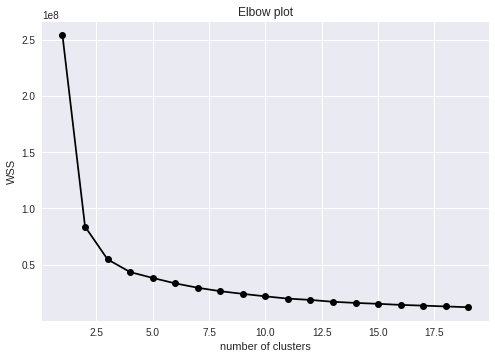

In [22]:
# setting the range of k
clusters = range(1, 20)

# running the clustering 
wss_list = []

for k in clusters:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(data_enc)
    wss_list.append(model.inertia_)

# plotting
_, ax = plt.subplots()
ax.plot(clusters, wss_list, '-o', color='black')
ax.set(title='Elbow plot', 
       xlabel='number of clusters', 
       ylabel='WSS');

#### Prediction Strength

##### Data split

In [108]:
# train/test split
X_train, X_test = train_test_split(data_enc, 
                                   test_size=0.1, 
                                   shuffle=True, 
                                   random_state=42)

##### Get closest centroid unoptimized

In [12]:
def get_closest_centroid(obs, centroids):
    '''
    Function for retrieving the closest centroid to the given observation 
    in terms of the Euclidean distance.
    
    Parameters
    ----------
    obs : array
        An array containing the observation to be matched to the nearest centroid
    centroids : array
        An array containing the centroids
    
    Returns
    -------
    min_centroid : array
        The centroid closes to the obs 
    '''
    min_distance = sys.float_info.max
    min_centroid = 0
    
    for c in centroids:
        dist = distance.euclidean(obs, c)
        if dist < min_distance:
            min_distance = dist
            min_centroid = c
            
    return min_centroid

##### Get closest centroid iptimized v1

In [13]:
def get_closest_centroid_optim(obs, centroids):
    '''
    Function for retrieving the closest centroid to the given observation 
    in terms of the Euclidean distance.
    
    Parameters
    ----------
    obs : array
        An array containing the observation to be matched to the nearest centroid
    centroids : array
        An array containing the centroids
    
    Returns
    -------
    min_centroid : array
        The centroid closes to the obs 
    '''
    
    distance = np.sqrt((np.square(centroids[:,np.newaxis]-obs).sum(axis=2)))
    idx_min_distance = np.argmin(distance)
    
    return centroids[idx_min_distance]

##### Get closest centroid optimized v2

In [14]:
def get_closest_centroid_optim_vectorized(obs, centroids):
    '''
    Function for retrieving the closest centroid to the given observation 
    in terms of the Euclidean distance.
    
    Parameters
    ----------
    obs : array
        An array containing the observation to be matched to the nearest centroid
    centroids : array
        An array containing the centroids
    
    Returns
    -------
    min_centroid : array
        The centroid closes to the obs 
    '''
    
    distance = np.sqrt((np.square(centroids[:,np.newaxis]-obs).sum(axis=2)))
    idx_min_distance = np.argmin(distance, axis = 0)
    
    return centroids[idx_min_distance]

##### Get prediction strength unoptimized

In [15]:
def get_prediction_strength(k, train_centroids, x_test, test_labels):
    '''
    Function for calculating the prediction strength of clustering
    
    Parameters
    ----------
    k : int
        The number of clusters
    train_centroids : array
        Centroids from the clustering on the training set
    x_test : array
        Test set observations
    test_labels : array
        Labels predicted for the test set
        
    Returns
    -------
    prediction_strength : float
        Calculated prediction strength
    '''
    n_test = len(x_test)
    
    # populate the co-membership matrix
    D = np.zeros(shape=(n_test, n_test))
    for x1, l1, c1 in zip(x_test, test_labels, list(range(n_test))):
        for x2, l2, c2 in zip(x_test, test_labels, list(range(n_test))):
            if tuple(x1) != tuple(x2):
                if tuple(get_closest_centroid(x1, train_centroids)) == tuple(get_closest_centroid(x2, train_centroids)):
                    D[c1,c2] = 1.0
    
    # calculate the prediction strengths for each cluster
    ss = []
    for j in range(k):
        s = 0
        examples_j = x_test[test_labels == j, :].tolist()
        n_examples_j = len(examples_j)
        for x1, l1, c1 in zip(x_test, test_labels, list(range(n_test))):
            for x2, l2, c2 in zip(x_test, test_labels, list(range(n_test))):
                if tuple(x1) != tuple(x2) and l1 == l2 and l1 == j:
                    s += D[c1,c2]
        ss.append(s / (n_examples_j * (n_examples_j - 1))) 

    prediction_strength = min(ss)

    return prediction_strength

##### Get prediction strength optimized

In [107]:
def get_prediction_strength_optim(k, train_centroids, x_test, test_labels):
    '''
    Function for calculating the prediction strength of clustering
    
    Parameters
    ----------
    k : int
        The number of clusters
    train_centroids : array
        Centroids from the clustering on the training set
    x_test : array
        Test set observations
    test_labels : array
        Labels predicted for the test set
        
    Returns
    -------
    prediction_strength : float
        Calculated prediction strength
    '''
    closest_cent = get_closest_centroid_optim_vectorized(x_test, train_centroids)
    
    co_membership = np.zeros((len(closest_cent), len(closest_cent)))
    for i in range(1, len(closest_cent)):
        diag = (closest_cent == np.roll(closest_cent, shift = i, axis = 0)).all(1)[i:]
        co_membership[range(i,len(closest_cent)),range(len(diag))] = diag
    co_membership = co_membership + co_membership.T - np.diag(np.diag(co_membership))
    
    # calculate the prediction strengths for each cluster
    n_test = len(x_test)
    ss = []
    for j in range(k):
        examples_j = x_test[test_labels == j, :].tolist()
        n_examples_j = len(examples_j)
        test_labels_co_mem = np.zeros((len(test_labels), len(test_labels)))
        for i in range(len(test_labels)):
            diag = (test_labels == np.roll(test_labels, shift = i)) & (test_labels == j)
            diag = diag[i:]
            test_labels_co_mem[range(i,len(test_labels)),range(len(diag))] = diag
        test_labels_co_mem = test_labels_co_mem + test_labels_co_mem.T - np.diag(np.diag(test_labels_co_mem))
        s = (co_membership * test_labels_co_mem).sum()
        ss.append(s / (n_examples_j * (n_examples_j - 1))) 

    prediction_strength = min(ss)

    return prediction_strength

##### Running Optimized Implementation

In [109]:
# running the clustering 
strengths = []
clusters = range(2, 15)
for k in clusters:
    model_train = KMeans(n_clusters=k, random_state=42).fit(X_train)
    model_test = KMeans(n_clusters=k, random_state=42).fit(X_test)
    
    pred_str = get_prediction_strength_optim(k, model_train.cluster_centers_, X_test, model_test.labels_)
    strengths.append(pred_str)

2
3
4
5
6
7
8
9
10
11
12
13
14


2
3
4
5
6
7
8
9
10
11
12
13
14


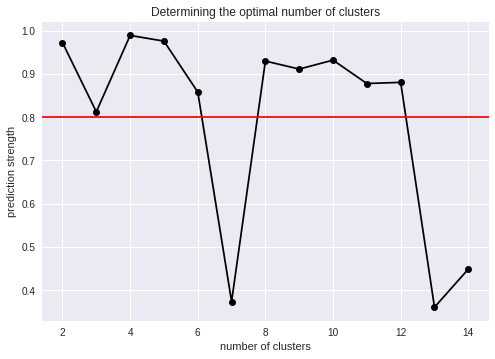

In [431]:
# plotting
### With 5% split for the testing data
_, ax = plt.subplots()
ax.plot(clusters, strengths, '-o', color='black')
ax.axhline(y=0.8, c='red');
ax.set(title='Determining the optimal number of clusters', 
       xlabel='number of clusters', 
       ylabel='prediction strength');

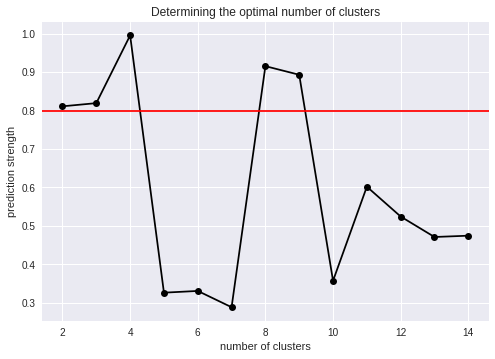

In [19]:
# plotting
### With 10% split for the testing data
_, ax = plt.subplots()
ax.plot(clusters, strengths, '-o', color='black')
ax.axhline(y=0.8, c='red');
ax.set(title='Determining the optimal number of clusters', 
       xlabel='number of clusters', 
       ylabel='prediction strength');

#### Fowlkes Mallows Score

In [ ]:
# setting the range of k
clusters = range(2, 20)
k_fowlkes_mallows = []
for k in clusters:
    model = KMeans(n_clusters = k, n_init = 100, random_state = 0)
    model.fit(data_enc)
    
    cluster = model.predict(data_enc)
    score   = fowlkes_mallows_score(data_enc, cluster)
    
    k_fowlkes_mallows.append(round(score,2))

In [ ]:
# plotting
_, ax = plt.subplots()
ax.plot(clusters, k_fowlkes_mallows, '-o', color='black')
ax.set(title='Calinski Harabaz Score over k clusters', 
       xlabel='number of clusters', 
       ylabel='Calinski Harabaz Score');

#### Calinski Harabaz Score

In [20]:
# setting the range of k
clusters = range(2, 20)
k_calinski_harabasz = []
for k in clusters:
    model = KMeans(n_clusters = k, random_state=42)
    model.fit(data_enc)
    
    cluster = model.predict(data_enc)
    score   = calinski_harabasz_score(data_enc, cluster)
    
    k_calinski_harabasz.append(round(score,2))

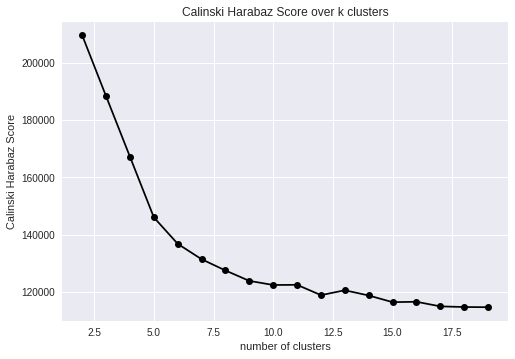

In [21]:
# plotting
_, ax = plt.subplots()
ax.plot(clusters, k_calinski_harabasz, '-o', color='black')
ax.set(title='Calinski Harabaz Score over k clusters', 
       xlabel='number of clusters', 
       ylabel='Calinski Harabaz Score');

#### Training Kmeans optimal Number of Clusters

In [24]:
final_kmeas = KMeans(n_clusters=4, random_state=42).fit(data_enc)
cluster_labels = final_kmeas.predict(data_enc)

#### Supervised Model to check feature importances

##### Results Functions

In [75]:
def plot_confusion_matrix(labels, prediction, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.get_cmap('Blues')):
    """ Dibuja la matriz de confusion de los resultados de clasificacion de un modelo.
    Se puede aplicar normalizacion ajustando 'normalize=True'. """

    n = len(classes)
    if len(prediction.shape) != 1:
        matrix = multilabel_confusion_matrix(labels, prediction).reshape(n,4)
    else:
        matrix = confusion_matrix(labels, prediction)

    size = 1.4 * len(classes)
    plt.figure(figsize=(size, size))
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))

    if len(prediction.shape) != 1:
        plt.xticks(tick_marks, ['True Negatives', 'False Negatives', 'False Positives', 'True Positives'], rotation=90)
    else:
        plt.xticks(tick_marks, classes, rotation=90)

    plt.yticks(tick_marks, classes)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, matrix[i, j],
                 horizontalalignment='center',
                 color='white' if matrix[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [76]:
def classifier_results(prediction, labels, classes, show_plots):
    """ Muestra los resultados de accuracy, presenta los resultados de precision, recall y f1-score
    y genera la matriz de confusion para el conjunto de datos."""

    print('\nAccuracy:\n{0:.2f}'.format(accuracy_score(labels, prediction)))

    print(classification_report(labels, prediction, digits=2, target_names = classes))
    
    if show_plots:
        plot_confusion_matrix(labels, prediction, classes)

    return classification_report(labels, prediction, digits=2, output_dict=True)

In [102]:
def plot_roc(classes, x, y):
    plt.figure(figsize=(8,8))
    for idx, label in enumerate(classes):
        roc_auc = auc(x[idx], y[idx])
        plt.plot(x[idx], y[idx], linewidth=2, label= str(label) + ' AUC = ' + '{0:.2f}'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', linewidth=2, linestyle='--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic ROC')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [104]:
def plot_precision_recall(classes, x, y, ap, f1):
    plt.figure(figsize=(8,8))
    for idx, label in enumerate(classes):
        roc_auc = auc(x[idx], y[idx])
        plt.plot(x[idx], y[idx], linewidth=2, label=str(label) + ': ' + 'AUC = ' + '{0:.2f}'.format(roc_auc) + ' - ' +
                                                                   'AP = ' + '{0:.2f}'.format(ap[idx]) + ' - ' +
                                                                   'F1 = ' + '{0:.2f}'.format(f1[idx]))
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [106]:
def set_proba_thresh(classes, classifier, validation_set, test_set, label_column, selected_chars, criterion, show_plots):
    fpr = {}
    tpr = {}
    thr_roc = {}
    precision = {}
    recall = {}
    thr_pr = {}
    ap = {}
    f1 = {}

    # Calculating ROC and Precision - Recall Plots
    features = validation_set

    validation_labels = np.array(validation_set[label_column].values.tolist())
    validation_predictions = classifier.predict(features)
    validation_probas = classifier.predict_proba(features)
    for idx, label in enumerate(classes):
        if len(validation_labels.shape) != 1:
            binary_labels = validation_labels[:,idx]
            f1[idx] = f1_score(binary_labels, validation_predictions[:, idx])
        else:
            binary_labels = np.array([label_validation == label
                                    for label_validation in validation_labels])
            f1[idx] = f1_score(binary_labels, validation_predictions == label)

        fpr[idx], tpr[idx], thr_roc[idx] = roc_curve(binary_labels, validation_probas[:, idx]) # ++++
        precision[idx], recall[idx], thr_pr[idx] = precision_recall_curve(binary_labels, validation_probas[:, idx])
        ap[idx] = average_precision_score(binary_labels, validation_probas[:, idx])


    if show_plots:
        plot_roc(classes, fpr, tpr)
        plot_precision_recall(classes, recall, precision, ap, f1)

    # Validation Data Results
    validation_result = []
    if criterion and isinstance(criterion, float):
        for lb_idx in thr_roc:
            for idx, value in enumerate(fpr[lb_idx]):
                if value >= criterion:
                    validation_result.append((classes[lb_idx],
                                              fpr[lb_idx][idx], tpr[lb_idx][idx], thr_roc[lb_idx][idx]))
                    break
    elif criterion and isinstance(criterion, dict):
        class_index_criterion = [classes.index(i) for i in criterion['clases']]
        for lb_idx in thr_roc:
            if lb_idx in class_index_criterion:
                for idx, value in enumerate(fpr[lb_idx]):
                    if value >= criterion['threshold'][class_index_criterion.index(lb_idx)]:
                        validation_result.append((classes[lb_idx],
                                                  fpr[lb_idx][idx], tpr[lb_idx][idx], thr_roc[lb_idx][idx]))
                        break
            else:
                j_scores = np.array(tpr[lb_idx]) - np.array(fpr[lb_idx])
                j_ordered = sorted(zip(j_scores.tolist(), fpr[lb_idx], tpr[lb_idx], thr_roc[lb_idx]))
                validation_result.append((classes[lb_idx],
                                          j_ordered[-1][1], j_ordered[-1][2], j_ordered[-1][3]))
    else:
        for lb_idx in thr_roc:
            j_scores = np.array(tpr[lb_idx]) - np.array(fpr[lb_idx])
            j_ordered = sorted(zip(j_scores.tolist(), fpr[lb_idx], tpr[lb_idx], thr_roc[lb_idx]))
            validation_result.append((classes[lb_idx],
                                      j_ordered[-1][1], j_ordered[-1][2], j_ordered[-1][3]))

    validation_result = pd.DataFrame(validation_result,
                                     columns=['class', 'false positive rate', 'true positive rate', 'threshold'])
    thresh = validation_result['threshold'].values

    # Testing Data Results
    if selected_chars:
        features = test_set
    else:
        features = test_set

    scores = classifier.predict_proba(features) # +++++
    prediction = classifier.predict(features)
    is_sure = np.sum(scores > thresh, axis=1) == 1
    prediction = np.array([label if sure else 'otro' for label, sure in zip(prediction, is_sure)], dtype=object)

    test_result = []
    test_labels = np.array(test_set[label_column].values.tolist())
    for idx, label in enumerate(classes):
        if len(test_labels.shape) != 1:
            binary_ground_truth = test_labels[:,idx]
        else:
            binary_ground_truth = [lb == label for lb in test_labels]
        binary_prediction = [lb == label for lb in prediction]
        tn = sum(np.logical_and(np.logical_not(binary_ground_truth), np.logical_not(binary_prediction)))
        fp = sum(np.logical_and(np.logical_not(binary_ground_truth), binary_prediction))
        fn = sum(np.logical_and(binary_ground_truth, np.logical_not(binary_prediction)))
        tp = sum(np.logical_and(binary_ground_truth, binary_prediction))
        test_result.append((label, fp/(fp+tn), tp/(tp+fn)))
    test_result = pd.DataFrame(test_result, columns=['class', 'false positive rate', 'true positive rate'])

    if show_plots:

        print('\n\033[1mVALIDATION RESULTS\n\033[0m')
        print('Threshold\n{}'.format(np.round(thresh, 2).tolist()))
        display(validation_result.drop('threshold', axis=1))

        print('\n\033[1mTESTING RESULTS\n\033[0m')
        display(test_result)

    return thresh

##### Data Spliting

In [93]:
# train/test split
X_train, X_test, Y_train, Y_test = train_test_split(data_enc, 
                                                    cluster_labels,
                                                    test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=42)

##### Training Model

In [30]:
data_enc.shape, cluster_labels.shape

((103290, 38), (103290,))

In [40]:
pd.DataFrame(cluster_labels, columns = ['Label'])['Label'].value_counts().to_frame()

,Label
0,33780
2,29590
1,23461
3,16459


In [95]:
clf = LogisticRegression(random_state=42,
                         max_iter = 100, 
                         solver = 'sag',
                         class_weight = 'balanced',
                         tol = 1e-4,
                         C = ).fit(X_train, Y_train)

##### Evaluating training results


Accuracy:
1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27043
           1       1.00      1.00      1.00     18778
           2       1.00      1.00      1.00     23590
           3       1.00      1.00      1.00     13221

    accuracy                           1.00     82632
   macro avg       1.00      1.00      1.00     82632
weighted avg       1.00      1.00      1.00     82632



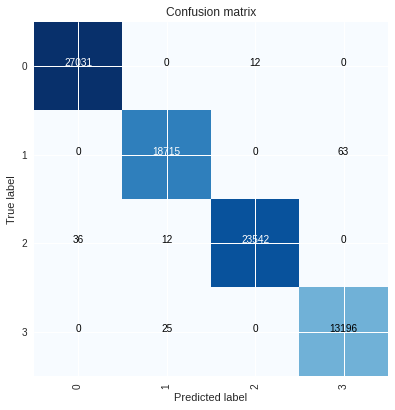

In [98]:
cr_train = classifier_results(prediction = pd.DataFrame(clf.predict(X_train))[0].astype(str).values, 
                               labels = pd.DataFrame(Y_train)[0].astype(str).values, 
                               classes = [str(cl) for cl in clf.classes_], 
                               show_plots = True)

##### Evaluating testing results


Accuracy:
1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6737
           1       1.00      1.00      1.00      4683
           2       1.00      1.00      1.00      6000
           3       1.00      1.00      1.00      3238

    accuracy                           1.00     20658
   macro avg       1.00      1.00      1.00     20658
weighted avg       1.00      1.00      1.00     20658



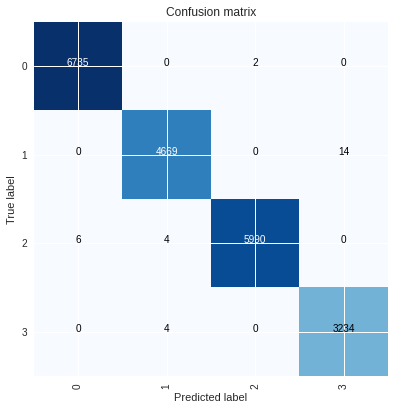

In [99]:
cr_test = classifier_results(prediction = pd.DataFrame(clf.predict(X_test))[0].astype(str).values, 
                           labels = pd.DataFrame(Y_test)[0].astype(str).values, 
                           classes = [str(cl) for cl in clf.classes_], 
                           show_plots = True)

##### Feature Importances

In [100]:
lg_coeffs = pd.DataFrame(clf.coef_, columns = data.columns).T.reset_index().rename(columns = {'index':'feature'})
lg_coeffs

,feature,0,1,2,3
0,genero,0.040859,-0.013834,0.018275,-0.045301
1,nacionalidad,1.461913,-0.198362,0.151015,-1.414566
2,anio_nacimiento,2.163814,-0.506110,1.204373,-2.862078
3,estado_civil,-0.009685,0.003584,0.032965,-0.026864
4,nivel_educativo,-0.004413,0.003537,-0.016689,0.017566
5,reconocimiento_etnico,0.421411,-0.400879,-0.026145,0.005613
6,diversidad_sexual,0.020536,0.021237,-0.028523,-0.013251
7,extranjero,0.000689,-0.000261,-0.000111,-0.000317
8,estado_ingreso,0.083131,-0.027792,0.035067,-0.090405
9,establecimiento,-3.546751,1.187094,-0.507795,2.867452


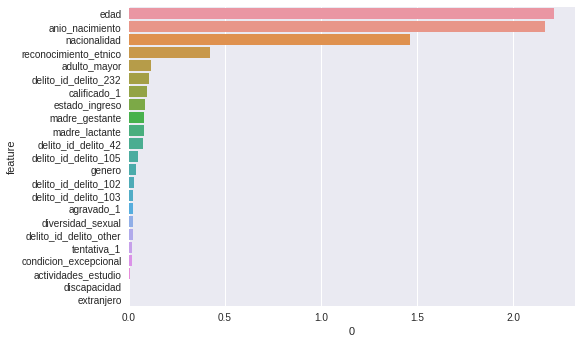

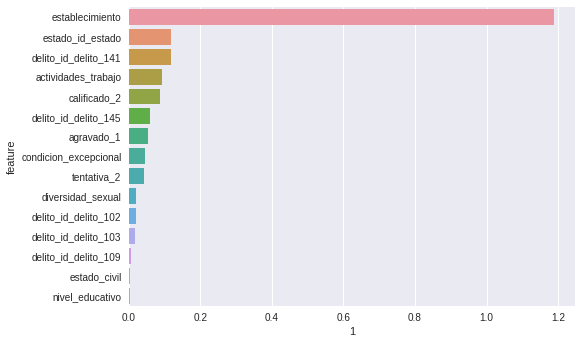

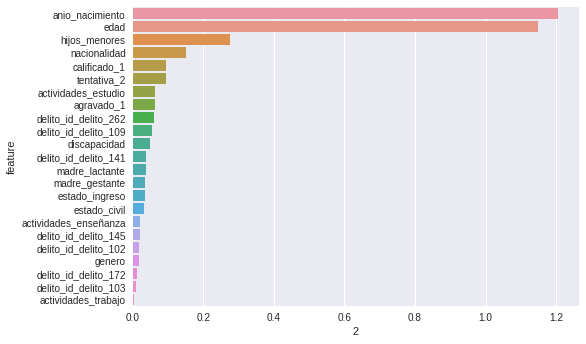

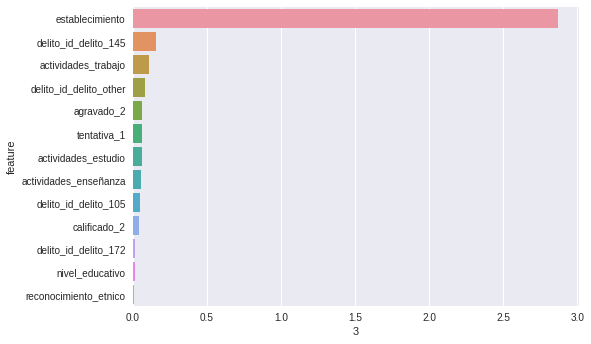

In [101]:
for i in range(4):
    d_cluster = lg_coeffs.sort_values(by=i, ascending = False)
    d_cluster = d_cluster[d_cluster[i] > 0]
    plt.figure(i)
    sns.barplot(x=i, y="feature" , data=d_cluster)